In [97]:
import pandas as pd
import tensorflow as tf
import numpy as np
import keras
from random import sample, shuffle
from math import floor
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale

In [106]:
class Dense(tf.Module):  # Denesly connected leyer
    # Note: No need for `in_features`
    def _linear_act(x):
        return x
    
    def __init__(self, out_features, act_func = _linear_act, name=None):
        super().__init__(name=name)
        self.is_built = False
        self.out_features = out_features  # Number of outputs
        self.act_func = act_func  # Activation function

    def __call__(self, x):
        # Create variables on first call.
        if not self.is_built:
            self.w = tf.Variable(
                tf.random.normal([x.shape[-1], self.out_features]), name='w')
            self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
            self.is_built = True

        y = tf.matmul(x, self.w) + self.b
        return self.act_func(y)


class Model(tf.Module):
    def __init__(self, layers=[], name=None):
        super().__init__(name=name)
        self.layers = layers

    # Feed forward on call
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def _loss(model, inputs, target_y):
    pred_y = model(inputs)
    return tf.reduce_mean(tf.square(target_y - pred_y))


def _grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = _loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


def _get_batches(X, Y, batch_size):
    n_data = len(X)
    # Shuffle data
    c = list(zip(X, Y))
    shuffle(c)
    X, Y = zip(*c)
    # Splitting into batches
    X, Y = np.array(X).astype('float32'), np.array(Y).astype('float32')
    x, y = [], []
    for i in range(0, n_data - batch_size, batch_size):
        x.append(X[i:i+batch_size])
        y.append(Y[i:i+batch_size])
    return x, y


def train(model, X, Y, epochs=10, batch_size=1,
          optimiser=tf.optimizers.Adam(0.01)):

    train_loss_results = []
    valid_loss_results = []
    test_loss_results = []
    
    for epoch in range(epochs):
        ##STATS##
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_loss_valid = tf.keras.metrics.Mean()
        epoch_loss_test = tf.keras.metrics.Mean()
        ##STATS##
        # Creating new batches for every epoch
        x, y = _get_batches(X, Y, batch_size)
        for i in range(0, len(x)):  # For all each batch
            loss_value, grads = _grad(model, x[i], y[i])
            ##STATS##
            epoch_loss_avg.update_state(loss_value)
            epoch_loss_valid.update_state(_loss(model, x_valid, y_valid))
            epoch_loss_test.update_state(_loss(model, x_test, y_test))
            ##STATS##
            optimiser.apply_gradients(zip(grads, model.trainable_variables))
            
        train_loss_results.append(epoch_loss_avg.result().numpy())
        valid_loss_results.append(epoch_loss_valid.result().numpy())
        test_loss_results.append(epoch_loss_test.result().numpy())
        if((epoch+1) % 10 == 0):
            print("Epoch: {}; Loss: {}".format(
                epoch+1, epoch_loss_avg.result().numpy()))
    return (train_loss_results, valid_loss_results, test_loss_results)

In [141]:
P_TRAIN = 0.92  # Fraction of dataset
P_VALID = 0.04

arecibo_df = pd.read_csv('Arecibo_DF')
nancay_df = pd.read_csv('Nancay_DF')

x_values = arecibo_df.drop(['M HI ', 'Name '], axis=1).values.astype('float32')
x_values = scale(x_values)
y_values = arecibo_df['M HI '].values.astype('float32')
y_values = np.reshape(y_values, (-1, 1))

n_data = len(x_values)
n_train = floor(n_data*P_TRAIN)
n_valid = floor(n_data*P_VALID)

c = list(zip(x_values, y_values))
shuffle(c)
x_shuf, y_shuf = zip(*c)

x_train, y_train = x_shuf[0:n_train], y_shuf[0:n_train]
x_valid, y_valid = x_shuf[n_train:n_train +
                            n_valid], y_shuf[n_train:n_train + n_valid]
x_test, y_test = x_shuf[n_train + n_valid:n_data], y_shuf[n_train + n_valid:n_data]

print(x_test)

(array([-0.0329734 ,  0.05315613, -0.8743945 ,  0.64897525, -0.29789066,
       -1.0934136 , -0.02733163, -0.12381878, -0.34184316, -0.18366492],
      dtype=float32), array([ 0.52742636, -0.4376899 , -0.4299545 ,  0.39445013, -0.28597283,
        1.2288948 ,  0.52004856, -0.12381878, -0.13192089, -0.2447569 ],
      dtype=float32), array([-0.33969823, -0.1104592 ,  0.13948493,  0.2618105 , -0.29789066,
       -0.30284047, -0.34184575, -0.58907723, -0.30510673, -0.14220963],
      dtype=float32), array([ 0.94603825, -0.1338328 , -0.29569605,  0.36218667, -0.28597283,
        3.6994355 ,  0.9384345 , -0.07609998, -0.37333146, -0.52403474],
      dtype=float32), array([ 1.4345796 ,  2.039914  , -2.16142   ,  1.2834957 , -0.8937678 ,
        0.53714347,  1.4423333 ,  3.8845618 ,  0.5608225 , -0.07893573],
      dtype=float32), array([-0.3469323 , -0.15720639,  0.44040835, -2.5558898 ,  2.5384848 ,
        0.24067858, -0.34957576, -0.2311861 , -0.17915341, -0.16097358],
      dtype=float32

C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [193]:
model = Model([Dense(16, tf.nn.elu),
               Dense(32, tf.nn.sigmoid), 
               Dense(32, tf.nn.sigmoid),
               Dense(16, tf.nn.relu),
               Dense(1)])
resultsSGD = train(model, x_train, y_train, epochs=1000,
                batch_size=8, optimiser=tf.optimizers.SGD(0.01))

Epoch: 10; Loss: 0.1521383672952652
Epoch: 20; Loss: 0.1062827780842781
Epoch: 30; Loss: 0.05993467941880226
Epoch: 40; Loss: 0.038490179926157
Epoch: 50; Loss: 0.03258703276515007
Epoch: 60; Loss: 0.02542543224990368
Epoch: 70; Loss: 0.022933263331651688
Epoch: 80; Loss: 0.0221908800303936
Epoch: 90; Loss: 0.017937611788511276
Epoch: 100; Loss: 0.015589027665555477
Epoch: 110; Loss: 0.013020270504057407
Epoch: 120; Loss: 0.011811187490820885
Epoch: 130; Loss: 0.010740521363914013
Epoch: 140; Loss: 0.009496541693806648
Epoch: 150; Loss: 0.008798294700682163
Epoch: 160; Loss: 0.00807217974215746
Epoch: 170; Loss: 0.007170911878347397
Epoch: 180; Loss: 0.006616030819714069
Epoch: 190; Loss: 0.006344679277390242
Epoch: 200; Loss: 0.005905232857912779
Epoch: 210; Loss: 0.00639314204454422
Epoch: 220; Loss: 0.005501474253833294
Epoch: 230; Loss: 0.005002651829272509
Epoch: 240; Loss: 0.004271533340215683
Epoch: 250; Loss: 0.004444039426743984
Epoch: 260; Loss: 0.004815238062292337
Epoch: 27

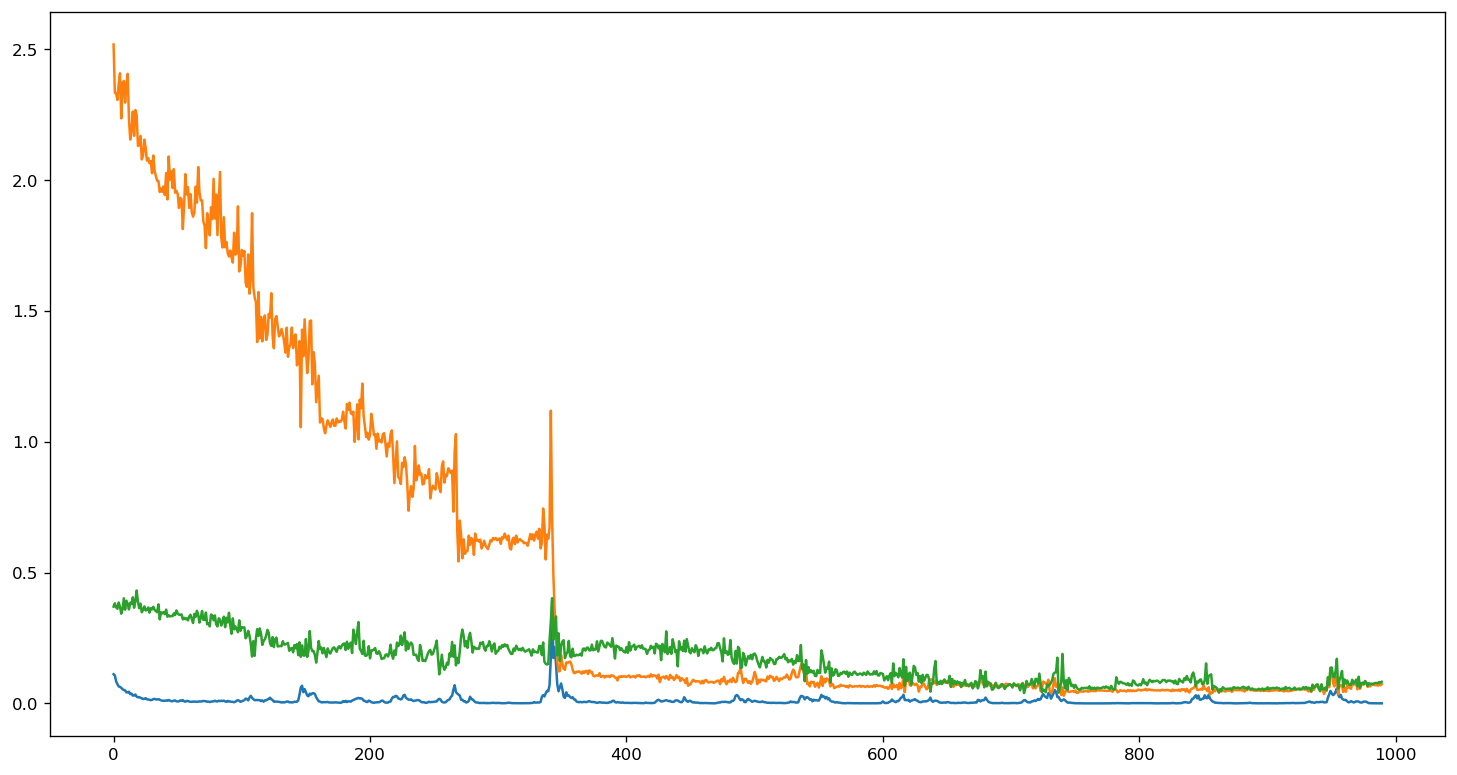

In [203]:
plt.figure(dpi=120, figsize=(15, 8))
plt.plot(resultsAdam[0][10:])
plt.plot(resultsAdam[1][10:])
plt.plot(resultsAdam[2][10:])

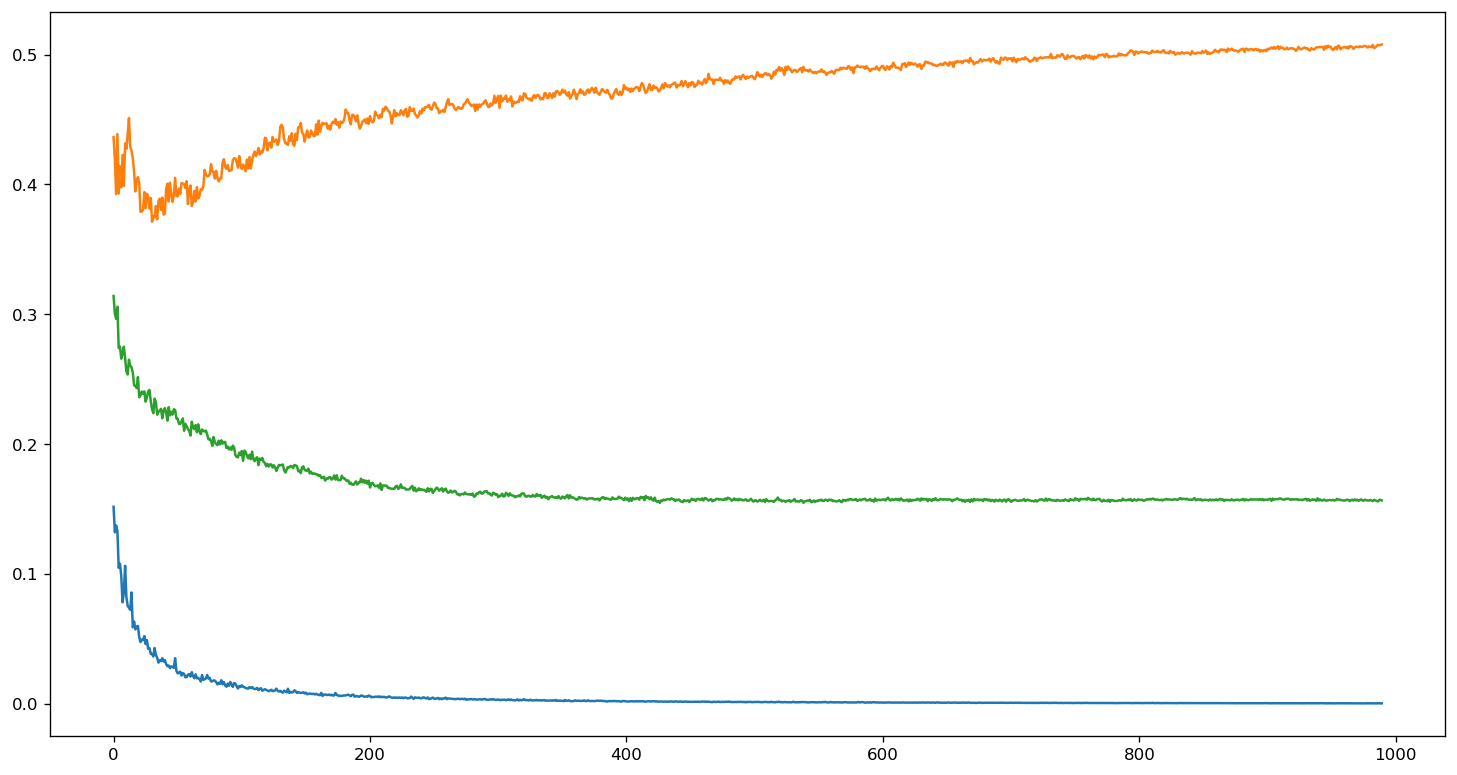

In [201]:
plt.figure(dpi=120, figsize=(15, 8))
plt.plot(resultsSGD[0][10:])
plt.plot(resultsSGD[1][10:])
plt.plot(resultsSGD[2][10:])

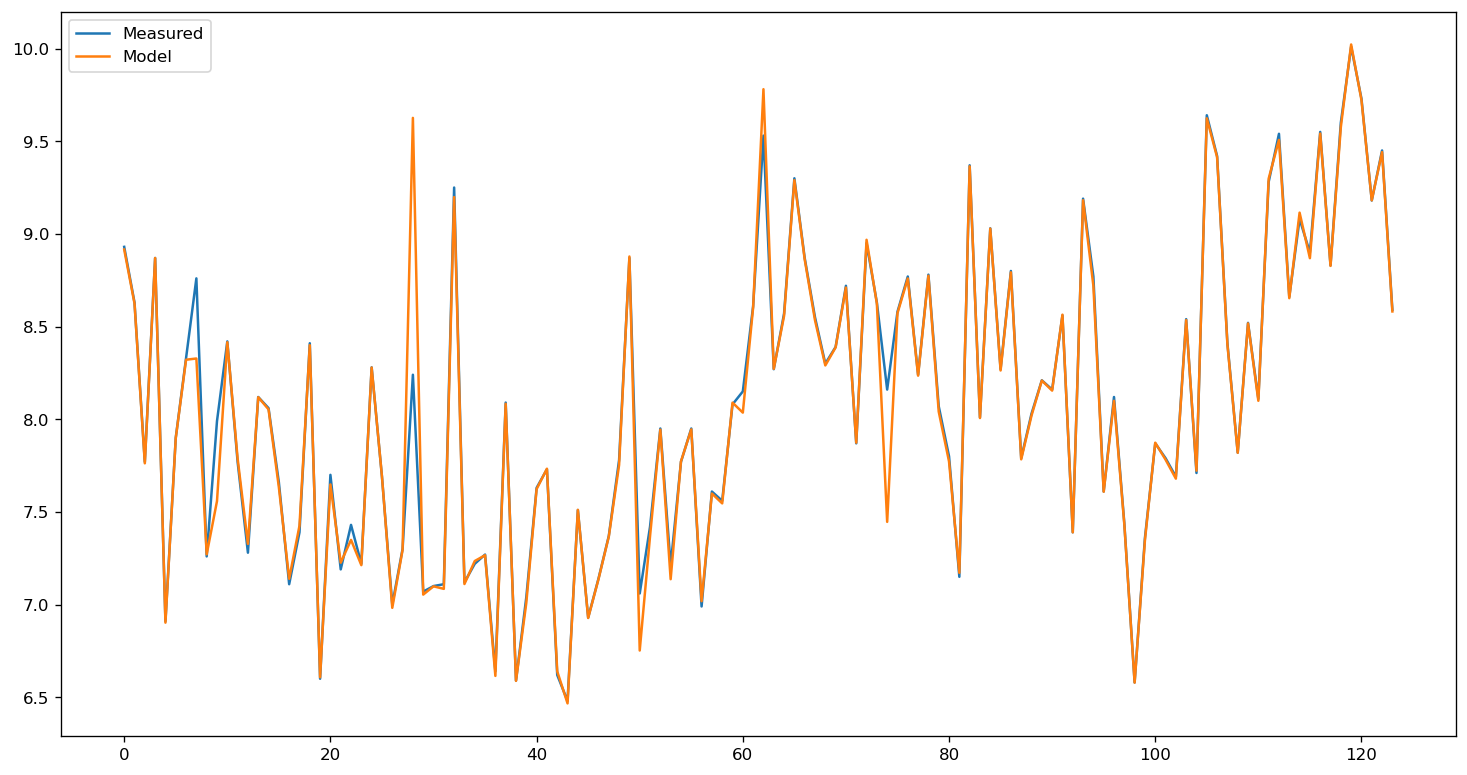

In [195]:
y_pred = model(x_values)
y = y_values
plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, len(y)), y)
model_l, = plt.plot(range(0, len(y)), y_pred)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [196]:
nancay_x = nancay_df.drop(['Name', 'MHI'], axis=1).values.astype('float32')
nancay_x = scale(nancay_x)

nancay_y = nancay_df['MHI'].values

C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


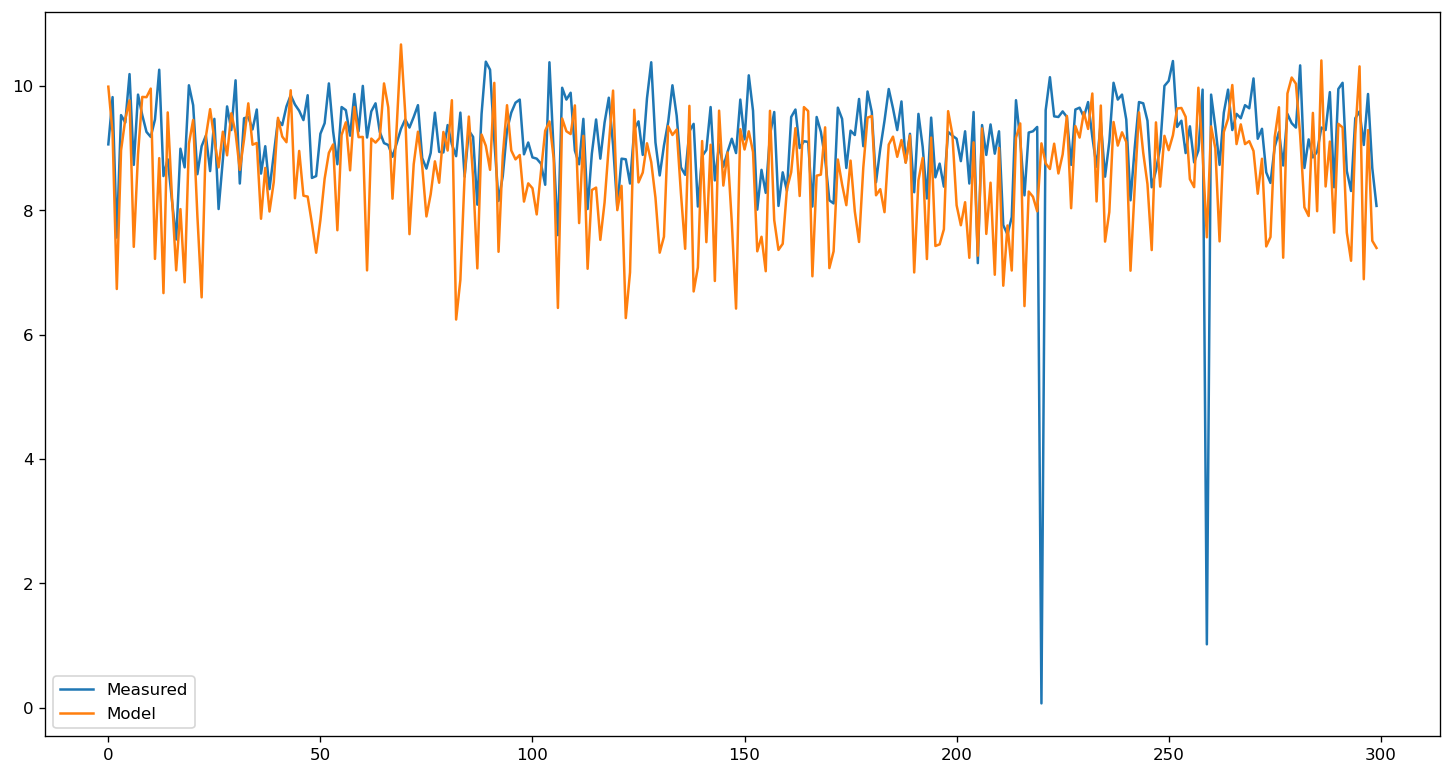

In [197]:
ran =300
nancay_x_sub = nancay_x[0:ran]
nancay_y_sub = nancay_y[0:ran]
nancay_pred_y = model(nancay_x_sub)

plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, ran), nancay_y_sub)
model_l, = plt.plot(range(0, ran), nancay_pred_y)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()